In [35]:
import pandas as pd

In [36]:
df_maf = pd.read_csv("maf_matched.csv", index_col=0)

In [37]:
df_groups = pd.read_csv("Allgroups_noDupIDs.csv", index_col=0)

In [38]:
df_maf.shape, df_groups.shape

((121, 26), (121, 24))

In [39]:
common = list(set(df_maf.index.tolist())&set(df_groups.index.tolist()))
print(len(common))

121


In [40]:
df_maf, df_groups = df_maf.loc[common], df_groups.loc[common]

In [41]:
print((df_maf.index==df_groups.index).all())

True


In [42]:
df = pd.concat([df_groups, df_maf], axis=1)

In [43]:
df.columns

Index(['barcode', 'patient', 'paper_Supervised.DNA.Methylation.Cluster',
       'paper_Original.Subtype', 'paper_Transcriptome.Subtype',
       'paper_IDH.specific.DNA.Methylation.Cluster', 'paper_IDH.status',
       'paper_IDH.specific.RNA.Expression.Cluster', 'paper_IDH.codel.subtype',
       'Project ID', 'Case ID', 'Case UUID', 'ID', 'File Name',
       'Data Category', 'Data Type', 'Sample Type', 'year of diagnosis',
       'age at index', 'days to death', 'gender',
       'vital status (0=alive, 1=dead)', 'Neural signature score',
       'Neural subgroup (0=low, 1=high)', 'Project ID', 'Case ID', 'Case UUID',
       'ID', 'File Name', 'Data Category', 'Data Type', 'Sample Type',
       'year of diagnosis', 'age at index', 'days to death', 'gender',
       'vital status (0=alive, 1=dead)', 'Neural signature score',
       'Neural subgroup (0=low, 1=high)', 'PTEN', 'EGFR', 'RB1', 'TP53', 'NF1',
       'PIK3R1', 'ATRX', 'PIK3CA', 'TERT', 'CIC', 'FUBP1'],
      dtype='object')

In [44]:
df = df.loc[:, ~df.columns.duplicated(keep="first")]

In [11]:
df.shape

(121, 35)

In [12]:
df.to_csv("merged_groups_maf.csv")

In [13]:
crosstab = pd.crosstab(df["Neural subgroup (0=low, 1=high)"], df["paper_Transcriptome.Subtype"])

In [14]:
crosstab.columns

Index(['CL', 'ME', 'NE', 'PN'], dtype='object', name='paper_Transcriptome.Subtype')

In [15]:
crosstab

paper_Transcriptome.Subtype,CL,ME,NE,PN
"Neural subgroup (0=low, 1=high)",,,,
0,19,18,2,1
1,12,5,1,9


In [16]:
import seaborn as sns
colors = sns.color_palette("colorblind", 2+4).as_hex()
df_nodes = pd.DataFrame(index=list(range(2+4)),
                     columns = ["ID", "Label", "Color"])
df_nodes["ID"] = df_nodes.index.tolist()
df_nodes["Color"] = colors
df_nodes["Label"] = crosstab.index.tolist()+crosstab.columns.tolist()

In [17]:
df_nodes

,ID,Label,Color
0,0,0,#0173b2
1,1,1,#de8f05
2,2,CL,#029e73
3,3,ME,#d55e00
4,4,NE,#cc78bc
5,5,PN,#ca9161


In [18]:
df_nodes["Label"].replace({0: "Low", 1: "High",
                         "CL": "Classical",
                         "ME": "Mesenchymal",
                         "NE": "Neural",
                         "PN": "Proneural"}, inplace=True)

In [19]:
df_nodes.Color = ["#f68612", "#91191e"] + df_nodes.Color.tolist()[2:]

In [20]:
df_links = pd.read_table("links_transcriptomic.txt", index_col=None, header=None)

In [21]:
df_links.columns = ["Source", "Target", "Value", "Link Color"]

In [22]:
crosstab

paper_Transcriptome.Subtype,CL,ME,NE,PN
"Neural subgroup (0=low, 1=high)",,,,
0,19,18,2,1
1,12,5,1,9


In [23]:
df_nodes

,ID,Label,Color
0,0,Low,#f68612
1,1,High,#91191e
2,2,Classical,#029e73
3,3,Mesenchymal,#d55e00
4,4,Neural,#cc78bc
5,5,Proneural,#ca9161


In [24]:
for row in crosstab.index:
    if row==0:
        l = "Low"
    else:
        l = "High"
    e = crosstab.loc[row].sum()
    df_nodes["Label"].replace({f"{l}": f"{l} (n={e})"}, inplace=True)
for col in crosstab.columns:
    if col=="CL":
        l = "Classical"
    elif col=="ME":
        l = "Mesenchymal"
    elif col=="NE":
        l = "Neural"
    else:
        l = "Proneural"
    e = crosstab[col].sum()
    df_nodes["Label"].replace({f"{l}": f"{l} (n={e})"}, inplace=True)

In [25]:
df_nodes

,ID,Label,Color
0,0,Low (n=40),#f68612
1,1,High (n=27),#91191e
2,2,Classical (n=31),#029e73
3,3,Mesenchymal (n=23),#d55e00
4,4,Neural (n=3),#cc78bc
5,5,Proneural (n=10),#ca9161


In [26]:
# imports
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [27]:
# Sankey plot setup
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      color = df_nodes['Color']
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
  )
)

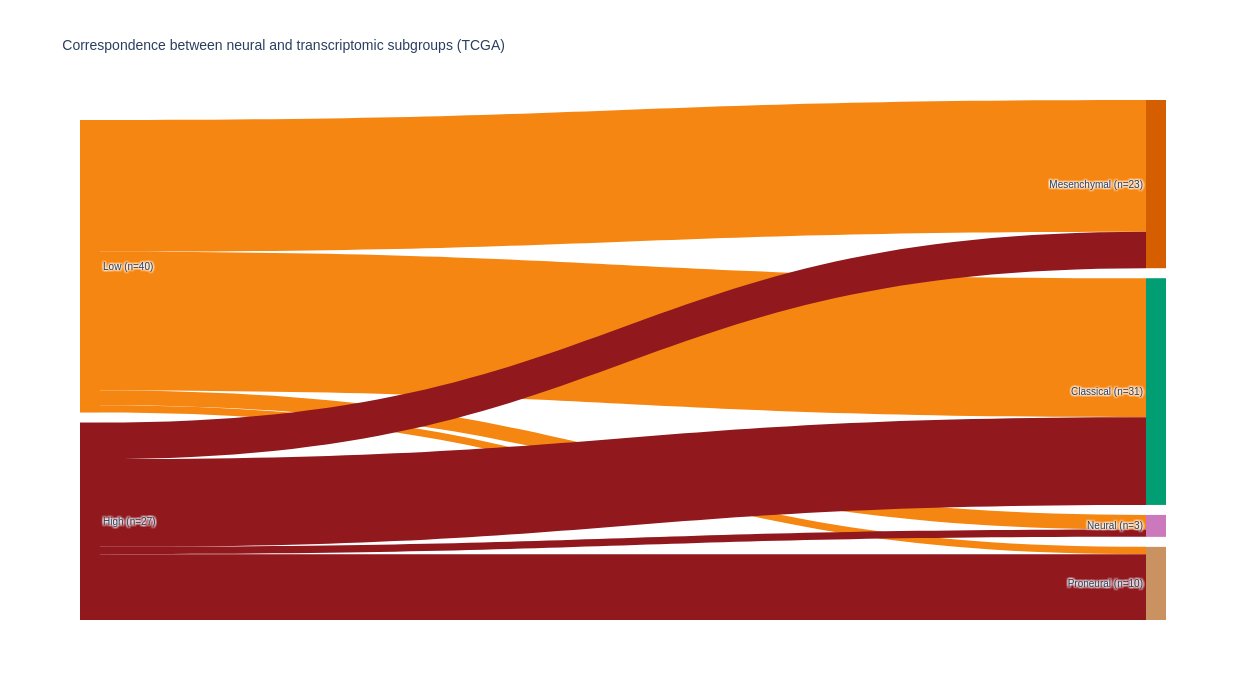

In [28]:
layout = dict(
        title = "Correspondence between neural and transcriptomic subgroups (TCGA)",
        height = 700,
        width=700,
        font = dict(size = 10),)

fig = dict(data=[data_trace], layout=layout)
fig = go.Figure(fig)
iplot(fig, validate=False)

In [29]:
fig.write_image("tcga_tx.png")
fig.write_image("tcga_tx.pdf", engine="kaleido")

In [30]:
df_groups

,barcode,patient,paper_Supervised.DNA.Methylation.Cluster,paper_Original.Subtype,paper_Transcriptome.Subtype,paper_IDH.specific.DNA.Methylation.Cluster,paper_IDH.status,paper_IDH.specific.RNA.Expression.Cluster,paper_IDH.codel.subtype,Project ID,...,Data Category,Data Type,Sample Type,year of diagnosis,age at index,days to death,gender,"vital status (0=alive, 1=dead)",Neural signature score,"Neural subgroup (0=low, 1=high)"
Sample ID,,,,,,,,,,,,,,,,,,,,,
TCGA-06-0152-01A,TCGA-06-0152-01A-02D-A45W-05,TCGA-06-0152,NaN,Mesenchymal,ME,NaN,WT,NaN,IDHwt,TCGA-GBM,...,DNA Methylation,Methylation Beta Value,Primary Tumor,1995,68,375,male,1.0,0.372,0
TCGA-06-6693-01A,TCGA-06-6693-01A-11D-1844-05,TCGA-06-6693,Classic-like,NaN,NaN,IDHwt-K1,WT,NaN,IDHwt,TCGA-GBM,...,DNA Methylation,Methylation Beta Value,Primary Tumor,1993,64,3667,female,1.0,0.392,0
TCGA-19-A60I-01A,TCGA-19-A60I-01A-12D-A33U-05,TCGA-19-A60I,Classic-like,NaN,NaN,IDHwt-K1,WT,NaN,IDHwt,TCGA-GBM,...,DNA Methylation,Methylation Beta Value,Primary Tumor,2012,39,'--,male,0.0,0.405,0
TCGA-76-6193-01A,TCGA-76-6193-01A-11D-1697-05,TCGA-76-6193,Mesenchymal-like,Mesenchymal,ME,IDHwt-K2,WT,NaN,IDHwt,TCGA-GBM,...,DNA Methylation,Methylation Beta Value,Primary Tumor,2010,78,82,male,1.0,0.380,0
TCGA-06-6698-01A,TCGA-06-6698-01A-11D-1844-05,TCGA-06-6698,LGm6-GBM,NaN,NaN,IDHwt-K3,WT,NaN,IDHwt,TCGA-GBM,...,DNA Methylation,Methylation Beta Value,Primary Tumor,2011,53,'--,female,0.0,0.400,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-76-6663-01A,TCGA-76-6663-01A-11D-1844-05,TCGA-76-6663,Classic-like,NaN,NaN,IDHwt-K1,WT,NaN,IDHwt,TCGA-GBM,...,DNA Methylation,Methylation Beta Value,Primary Tumor,2011,44,567,female,1.0,0.417,1
TCGA-26-5134-01A,TCGA-26-5134-01A-01D-1481-05,TCGA-26-5134,Mesenchymal-like,Proneural,NaN,IDHwt-K2,WT,IDHwt-R3,IDHwt,TCGA-GBM,...,DNA Methylation,Methylation Beta Value,Primary Tumor,2009,74,'--,male,0.0,0.442,1
TCGA-RR-A6KC-01A,TCGA-RR-A6KC-01A-31D-A33U-05,TCGA-RR-A6KC,Classic-like,NaN,NaN,IDHwt-K1,WT,NaN,IDHwt,TCGA-GBM,...,DNA Methylation,Methylation Beta Value,Primary Tumor,2010,55,625,male,1.0,0.336,0


In [31]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
sns.set(style="ticks", font_scale=1.2)
plt.rcParams["font.family"] = ["Inter"]

In [34]:
tmp

,barcode,patient,paper_Supervised.DNA.Methylation.Cluster,paper_Original.Subtype,paper_Transcriptome.Subtype,paper_IDH.specific.DNA.Methylation.Cluster,paper_IDH.status,paper_IDH.specific.RNA.Expression.Cluster,paper_IDH.codel.subtype,Project ID,...,Data Type,Sample Type,year of diagnosis,age at index,days to death,gender,"vital status (0=alive, 1=dead)",Neural signature score,"Neural subgroup (0=low, 1=high)",months
Sample ID,,,,,,,,,,,,,,,,,,,,,
TCGA-06-0152-01A,TCGA-06-0152-01A-02D-A45W-05,TCGA-06-0152,NaN,Mesenchymal,ME,NaN,WT,NaN,IDHwt,TCGA-GBM,...,Methylation Beta Value,Primary Tumor,1995,68,375,male,1.0,0.372,0,12.328632
TCGA-76-6193-01A,TCGA-76-6193-01A-11D-1697-05,TCGA-76-6193,Mesenchymal-like,Mesenchymal,ME,IDHwt-K2,WT,NaN,IDHwt,TCGA-GBM,...,Methylation Beta Value,Primary Tumor,2010,78,82,male,1.0,0.380,0,2.695861
TCGA-26-5135-01A,TCGA-26-5135-01A-01D-1481-05,TCGA-26-5135,Mesenchymal-like,Proneural,ME,IDHwt-K2,WT,IDHwt-R3,IDHwt,TCGA-GBM,...,Methylation Beta Value,Primary Tumor,2009,72,270,female,1.0,0.457,1,8.876615
TCGA-19-5947-01A,TCGA-19-5947-01A-11D-1697-05,TCGA-19-5947,Mesenchymal-like,Mesenchymal,ME,IDHwt-K2,WT,NaN,IDHwt,TCGA-GBM,...,Methylation Beta Value,Primary Tumor,2010,47,202,female,1.0,0.245,0,6.641023
TCGA-19-1389-01A,TCGA-19-1389-01A-01D-0595-05,TCGA-19-1389,LGm6-GBM,Mesenchymal,ME,IDHwt-K3,WT,NaN,IDHwt,TCGA-GBM,...,Methylation Beta Value,Primary Tumor,2008,51,141,male,1.0,0.314,0,4.635566
TCGA-76-6282-01A,TCGA-76-6282-01A-11D-1697-05,TCGA-76-6282,Mesenchymal-like,Mesenchymal,ME,IDHwt-K2,WT,NaN,IDHwt,TCGA-GBM,...,Methylation Beta Value,Primary Tumor,2007,63,519,male,1.0,0.286,0,17.062827
TCGA-28-5214-01A,TCGA-28-5214-01A-01D-1481-05,TCGA-28-5214,Classic-like,Mesenchymal,ME,IDHwt-K1,WT,NaN,IDHwt,TCGA-GBM,...,Methylation Beta Value,Primary Tumor,2010,53,713,male,1.0,0.406,0,23.440839
TCGA-06-0650-01A,TCGA-06-0650-01A-02D-1697-05,TCGA-06-0650,LGm6-GBM,Mesenchymal,ME,IDHwt-K3,WT,NaN,IDHwt,TCGA-GBM,...,Methylation Beta Value,Primary Tumor,2007,39,717,female,1.0,0.345,0,23.572344
TCGA-26-5136-01B,TCGA-26-5136-01B-01D-1481-05,TCGA-26-5136,Mesenchymal-like,Mesenchymal,ME,IDHwt-K2,WT,IDHwt-R2,IDHwt,TCGA-GBM,...,Methylation Beta Value,Primary Tumor,2009,78,577,female,1.0,0.406,0,18.969655


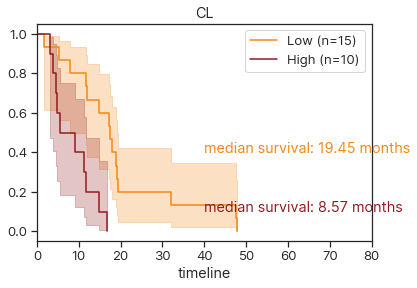

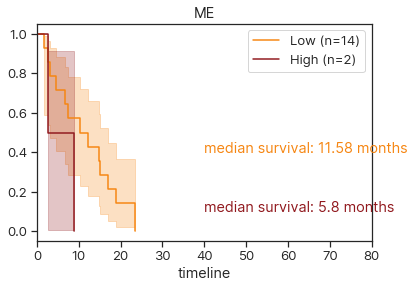

In [33]:
for gr in sorted(['CL', 'ME']):
    
    tmp = df_groups.loc[df[df["paper_Transcriptome.Subtype"]==gr].index]
    tmp = tmp[tmp["vital status (0=alive, 1=dead)"]==1]
    tmp["days to death"] = tmp["days to death"].astype(int)
    tmp["months"] = tmp["days to death"]/30.417
    groups = tmp["Neural subgroup (0=low, 1=high)"]

    i1 = (groups == 0)
    i2 = (groups == 1)

    durations = pd.DataFrame(tmp["months"], index=tmp.index)
    event_observed = tmp["vital status (0=alive, 1=dead)"]

    ## fit the model for 1st cohort
    kmf1 = KaplanMeierFitter()

    n = i1.sum()
    kmf1.fit(durations.loc[i1.tolist()], event_observed.loc[i1.tolist()], label=f'Low (n={n})')
    a1 = kmf1.plot(ci_show=True, color="#f68612")
    n = durations.loc[i1.tolist()].mean()[0]
    plt.text(40, 0.4, f"median survival: {round(n,2)} months", color="#f68612")

    ## fit the model for 2nd cohort
    n = i2.sum()
    kmf1.fit(durations.loc[i2.tolist()], event_observed.loc[i2.tolist()], label=f'High (n={n})')
    kmf1.plot(ax=a1, ci_show=True, color="#91191e")
    n = durations.loc[i2.tolist()].mean()[0]

    plt.text(40, 0.1, f"median survival: {round(n,2)} months", color="#91191e")


    plt.xlim(0,80)
    plt.title(gr)
    plt.savefig(f"{gr}_KM.pdf", bbox_inches="tight")
    plt.show()

Text(0.5, 1.0, 'CL')

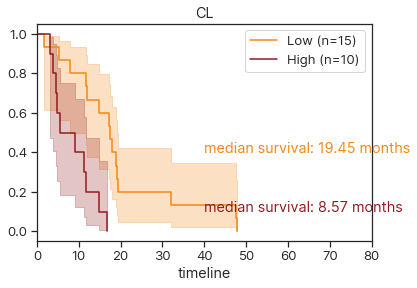

In [83]:
tmp = df_groups.loc[df[df["paper_Transcriptome.Subtype"]=="ME"].index]
tmp = tmp[tmp["vital status (0=alive, 1=dead)"]==1]

In [84]:
tmp["days to death"] = tmp["days to death"].astype(int)
tmp["months"] = tmp["days to death"]/30.417

In [85]:
tmp["Neural subgroup (0=low, 1=high)"].value_counts()

0    14
1     2
Name: Neural subgroup (0=low, 1=high), dtype: int64

In [86]:
tmp.groupby("Neural subgroup (0=low, 1=high)").agg("mean")

/tmp/ipykernel_59088/3355537109.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,year of diagnosis,age at index,days to death,"vital status (0=alive, 1=dead)",Neural signature score,months
"Neural subgroup (0=low, 1=high)",,,,,,
0,2005.785714,63.428571,352.142857,1.0,0.316857,11.577173
1,2009.500000,73.500000,176.500000,1.0,0.440500,5.802676


In [87]:
from lifelines import KaplanMeierFitter

In [88]:
groups = tmp["Neural subgroup (0=low, 1=high)"]

i1 = (groups == 0)
i2 = (groups == 1)

In [89]:
durations = pd.DataFrame(tmp["months"], index=tmp.index)
event_observed = tmp["vital status (0=alive, 1=dead)"]

In [90]:
import matplotlib.pyplot as plt
sns.set(style="ticks", font_scale=1.2)
plt.rcParams["font.family"] = ["Inter"]

Text(0.5, 1.0, 'ME')

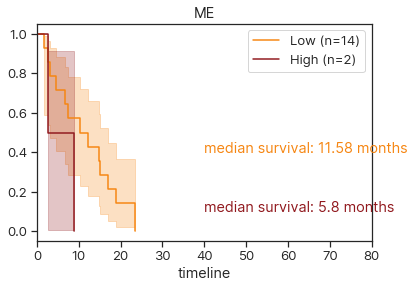

In [92]:
## fit the model for 1st cohort
kmf1 = KaplanMeierFitter()

n = i1.sum()
kmf1.fit(durations.loc[i1.tolist()], event_observed.loc[i1.tolist()], label=f'Low (n={n})')
a1 = kmf1.plot(ci_show=True, color="#f68612")
n = durations.loc[i1.tolist()].mean()[0]
plt.text(40, 0.4, f"median survival: {round(n,2)} months", color="#f68612")

## fit the model for 2nd cohort
n = i2.sum()
kmf1.fit(durations.loc[i2.tolist()], event_observed.loc[i2.tolist()], label=f'High (n={n})')
kmf1.plot(ax=a1, ci_show=True, color="#91191e")
n = durations.loc[i2.tolist()].mean()[0]

plt.text(40, 0.1, f"median survival: {round(n,2)} months", color="#91191e")


plt.xlim(0,80)
plt.title("ME")

-----

In [30]:
crosstab = pd.crosstab(df["Neural subgroup (0=low, 1=high)"], df["paper_Supervised.DNA.Methylation.Cluster"])

In [31]:
crosstab

paper_Supervised.DNA.Methylation.Cluster,Classic-like,LGm6-GBM,Mesenchymal-like
"Neural subgroup (0=low, 1=high)",,,
0,35,3,26
1,17,3,27


In [32]:
import seaborn as sns
colors = sns.color_palette("colorblind", 2+3).as_hex()
df_nodes = pd.DataFrame(index=list(range(2+3)),
                     columns = ["ID", "Label", "Color"])
df_nodes["ID"] = df_nodes.index.tolist()
df_nodes["Color"] = colors
df_nodes["Label"] = crosstab.index.tolist()+crosstab.columns.tolist()

In [33]:
df_nodes["Label"].replace({0: "Low", 1: "High"}, inplace=True)

In [34]:
df_links = pd.DataFrame(index=list(range(2*3)),
                        columns=["Source", "Target", "Value", "Link Color"])
df_links["Link Color"] = ["#f68612"]*3 + ["#91191e"]*3
df_links["Target"] = crosstab.columns.tolist() + crosstab.columns.tolist()
df_links["Source"] = ["Low"]*3 + ["High"]*3

In [35]:
df_nodes.Color = ["#f68612", "#91191e"] + df_nodes.Color.tolist()[2:]

In [36]:
for idx in crosstab.index:
    for col in crosstab.columns:
        val = crosstab.loc[idx, col]
        # print(val)
        if idx==0:
            gr="Low"
        else:
            gr="High"
        df_links.loc[(df_links.Source==gr)&(df_links.Target==col), "Value"] = val

In [37]:
mapping = dict(zip(df_nodes.Label.tolist(),
         df_nodes.ID.tolist()))
df_links.replace(mapping, inplace=True)

In [38]:
for row in crosstab.index:
    if row==0:
        l = "Low"
    else:
        l = "High"
    e = crosstab.loc[row].sum()
    df_nodes["Label"].replace({f"{l}": f"{l} (n={e})"}, inplace=True)
for col in crosstab.columns:

    e = crosstab[col].sum()
    df_nodes["Label"].replace({f"{col}": f"{col} (n={e})"}, inplace=True)

In [39]:
df_links

,Source,Target,Value,Link Color
0,0,2,35,#f68612
1,0,3,3,#f68612
2,0,4,26,#f68612
3,1,2,17,#91191e
4,1,3,3,#91191e
5,1,4,27,#91191e


In [40]:
# imports
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [41]:
df_links

,Source,Target,Value,Link Color
0,0,2,35,#f68612
1,0,3,3,#f68612
2,0,4,26,#f68612
3,1,2,17,#91191e
4,1,3,3,#91191e
5,1,4,27,#91191e


In [42]:
df_links["Source"] = df_links["Source"].astype("category").cat.reorder_categories([0,1])
df_links["Target"] = df_links["Target"].astype("category").cat.reorder_categories([2,3,4])

In [43]:
df_links

,Source,Target,Value,Link Color
0,0,2,35,#f68612
1,0,3,3,#f68612
2,0,4,26,#f68612
3,1,2,17,#91191e
4,1,3,3,#91191e
5,1,4,27,#91191e


In [44]:
df_nodes

,ID,Label,Color
0,0,Low (n=64),#f68612
1,1,High (n=47),#91191e
2,2,Classic-like (n=52),#029e73
3,3,LGm6-GBM (n=6),#d55e00
4,4,Mesenchymal-like (n=53),#cc78bc


In [45]:
# Sankey plot setup
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  (0.,1.),
      y =  (0.,1.)
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      color = df_nodes['Color']
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
  )
)

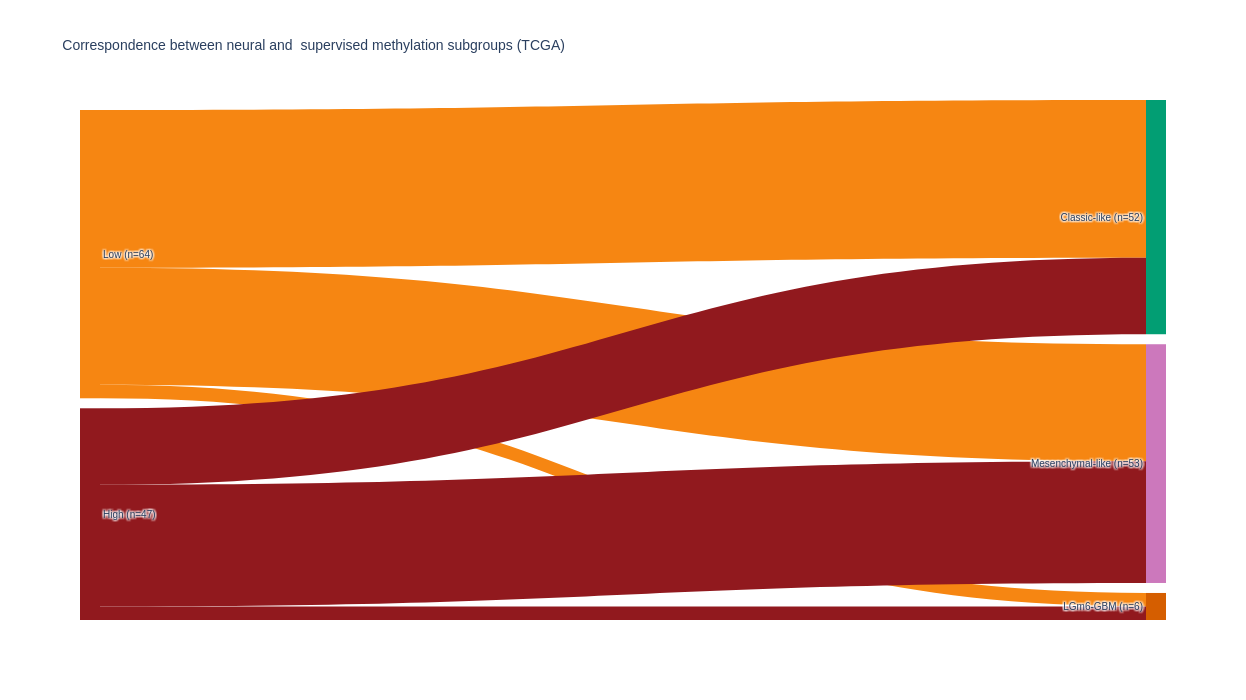

In [46]:
layout = dict(
        title = "Correspondence between neural and \nsupervised methylation subgroups (TCGA)",
    height = 700,
    width=700,
    font = dict(
      size = 10),)

fig = dict(data=[data_trace], layout=layout, arrangement='snap',)
fig = go.Figure(fig, )
iplot(fig, validate=False)

In [47]:
fig.write_image("tcga_methSup.png")
fig.write_image("tcga_methSup.pdf")

-----

In [48]:
df

,barcode,patient,paper_Supervised.DNA.Methylation.Cluster,paper_Original.Subtype,paper_Transcriptome.Subtype,paper_IDH.specific.DNA.Methylation.Cluster,paper_IDH.status,paper_IDH.specific.RNA.Expression.Cluster,paper_IDH.codel.subtype,Project ID,...,EGFR,RB1,TP53,NF1,PIK3R1,ATRX,PIK3CA,TERT,CIC,FUBP1
Sample ID,,,,,,,,,,,,,,,,,,,,,
TCGA-28-5213-01A,TCGA-28-5213-01A-01D-1481-05,TCGA-28-5213,Mesenchymal-like,Mesenchymal,ME,IDHwt-K2,WT,IDHwt-R2,IDHwt,TCGA-GBM,...,Missense_Mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation
TCGA-19-5959-01A,TCGA-19-5959-01A-11D-1697-05,TCGA-19-5959,Classic-like,Classical,CL,IDHwt-K1,WT,NaN,IDHwt,TCGA-GBM,...,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation
TCGA-28-5209-01A,TCGA-28-5209-01A-01D-1481-05,TCGA-28-5209,Classic-like,Mesenchymal,CL,IDHwt-K1,WT,IDHwt-R1,IDHwt,TCGA-GBM,...,Missense_Mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation
TCGA-19-4065-01A,TCGA-19-4065-01A-01D-2004-05,TCGA-19-4065,NaN,NaN,ME,NaN,NaN,NaN,NaN,TCGA-GBM,...,No_mutation,No_mutation,Missense_Mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation
TCGA-4W-AA9T-01A,TCGA-4W-AA9T-01A-11D-A392-05,TCGA-4W-AA9T,Classic-like,NaN,NaN,IDHwt-K1,WT,NaN,IDHwt,TCGA-GBM,...,Missense_Mutation,No_mutation,No_mutation,No_mutation,No_mutation,Missense_Mutation,No_mutation,No_mutation,No_mutation,No_mutation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-19-5958-01A,TCGA-19-5958-01A-11D-1697-05,TCGA-19-5958,Mesenchymal-like,Classical,NE,IDHwt-K2,WT,NaN,IDHwt,TCGA-GBM,...,No_mutation,No_mutation,No_mutation,No_mutation,Missense_Mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation
TCGA-19-5954-01A,TCGA-19-5954-01A-11D-1697-05,TCGA-19-5954,Mesenchymal-like,Classical,CL,IDHwt-K2,WT,NaN,IDHwt,TCGA-GBM,...,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,Multiple,No_mutation,No_mutation,No_mutation
TCGA-06-6694-01A,TCGA-06-6694-01A-12D-1844-05,TCGA-06-6694,Mesenchymal-like,NaN,NaN,IDHwt-K2,WT,NaN,IDHwt,TCGA-GBM,...,No_mutation,No_mutation,Missense_Mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation,No_mutation


In [49]:
crosstab = pd.crosstab(df["paper_Original.Subtype"], df["paper_Supervised.DNA.Methylation.Cluster"])
crosstab

paper_Supervised.DNA.Methylation.Cluster,Classic-like,LGm6-GBM,Mesenchymal-like
paper_Original.Subtype,,,
Classical,12,0,12
Mesenchymal,3,3,11
Neural,6,0,2
Proneural,6,0,7


In [50]:
crosstab = pd.crosstab(df["Neural subgroup (0=low, 1=high)"], df["paper_Transcriptome.Subtype"])
crosstab

paper_Transcriptome.Subtype,CL,ME,NE,PN
"Neural subgroup (0=low, 1=high)",,,,
0,19,18,2,1
1,12,5,1,9


In [45]:
crosstab = pd.crosstab(df["paper_Original.Subtype"], df["paper_Transcriptome.Subtype"])
crosstab

paper_Transcriptome.Subtype,CL,ME,NE,PN
paper_Original.Subtype,,,,
Classical,21,2,1,0
Mesenchymal,4,16,0,1
Neural,2,3,2,1
Proneural,4,1,0,8


In [51]:
crosstab = pd.crosstab(df["Neural subgroup (0=low, 1=high)"], df["paper_Transcriptome.Subtype"])
crosstab

paper_Transcriptome.Subtype,CL,ME,NE,PN
"Neural subgroup (0=low, 1=high)",,,,
0,19,18,2,1
1,12,5,1,9


In [52]:
crosstab = pd.crosstab(df["Neural subgroup (0=low, 1=high)"], df["paper_Original.Subtype"])
crosstab

paper_Original.Subtype,Classical,Mesenchymal,Neural,Proneural
"Neural subgroup (0=low, 1=high)",,,,
0,16,16,7,3
1,10,5,2,11
